In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set_context('talk')

## Data Preparation

In [2]:
df_raw = pd.read_csv("online_retail_II.csv")
df_raw.shape

(1067371, 8)

In [3]:
df_raw.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [4]:
df_raw['Customer ID'] = df_raw['Customer ID'].astype(str).apply(lambda x: x.split('.')[0])
df_raw['InvoiceDate'] = pd.to_datetime(df_raw['InvoiceDate'])
df_raw['subtotal'] = df_raw['Quantity'] * df_raw['Price']

In [5]:
from pandas.tseries.offsets import MonthEnd

df_raw['month_end_date'] = df_raw['InvoiceDate'] + MonthEnd(1)

In [6]:
# df_raw['InvoiceDate'] = df_raw['InvoiceDate'].dt.date

In [7]:
df_raw['InvoiceDate'].min()

Timestamp('2009-12-01 07:45:00')

In [8]:
df_raw['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

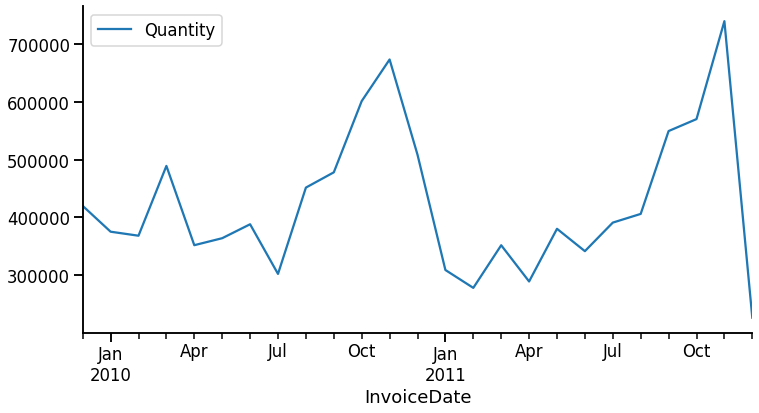

In [9]:
f, ax = plt.subplots(figsize=(12,6))
df_raw.groupby(pd.Grouper(key='InvoiceDate', freq='1M')).agg({'Quantity': 'sum'}).plot.line(ax=ax);
sns.despine();

## Problem definition

- Forecast horizon = 6 months ahead

In [10]:
FORECAST_HORIZON_MONTH = 6
TEST_START_DATE = df_raw['month_end_date'].max() - np.timedelta64(6, 'M')
TEST_START_DATE = pd.to_datetime((TEST_START_DATE - MonthEnd(1)).date().strftime('%Y-%m-%d'))

mask_train = df_raw['month_end_date'] < TEST_START_DATE
df_train = df_raw[mask_train].copy().reset_index().drop(labels=['index'], axis=1)
df_test = df_raw[~mask_train].copy().reset_index().drop(labels=['index'], axis=1)

In [11]:
df_train.shape

(733209, 11)

## Data Cleaning

TO DO:

- [ ] Handle negative price
- [ ] Handle negative quantity
- [ ] Wrap as a function, should be used on the test set as well

In [12]:
mask_neg_price = (df_train['Price'] < 0)
print("Remove {} records with negative price.".format(df_train[mask_neg_price].shape[0]))

df_train = df_train[~mask_neg_price].copy()

Remove 3 records with negative price.


In [13]:
mask_neg_qty = (df_train['Quantity'] < 0)

print("Records with negative quantity: {:,.0f} ~ {:,.2%} of the records.".format(
    df_train[mask_neg_qty].shape[0],
      df_train[mask_neg_qty].shape[0] / df_train.shape[0]
     ))

Records with negative quantity: 16,746 ~ 2.28% of the records.


In [14]:
df_train[mask_neg_qty].head()

,index,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,subtotal,month_end_date
178,178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321,Australia,-35.4,2009-12-31 10:33:00
179,179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321,Australia,-9.9,2009-12-31 10:33:00
180,180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321,Australia,-17.0,2009-12-31 10:33:00
181,181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321,Australia,-12.6,2009-12-31 10:33:00
182,182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321,Australia,-35.4,2009-12-31 10:33:00


In [15]:
## we do not find correction of the qty using the same invoice number
df_train[
    (df_train['Invoice'] == 'C489449') &
    (df_train['StockCode'] == '85206A')
]

,index,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,subtotal,month_end_date
179,179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321,Australia,-9.9,2009-12-31 10:33:00


In [16]:
## the gap of invoice date is quite long (3 months)
## not sure if it refers to the same thing
df_train[
    (df_train['InvoiceDate'] != pd.to_datetime('2009-12-01')) &
    (df_train['StockCode'] == '85206A') &
    (df_train['Customer ID'] == '16321')
]

,index,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,subtotal,month_end_date
179,179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321,Australia,-9.9,2009-12-31 10:33:00
188,188,489450,85206A,CREAM FELT EASTER EGG BASKET,6,2009-12-01 10:36:00,1.65,16321,Australia,9.9,2009-12-31 10:36:00
135099,135099,502275,85206A,CREAM FELT EASTER EGG BASKET,12,2010-03-23 16:01:00,1.65,16321,Australia,19.8,2010-03-31 16:01:00


In [17]:
## and we don't find a "correction" of this item
df_train[
    (df_train['InvoiceDate'] != pd.to_datetime('2009-12-01')) &
    (df_train['StockCode'] == '21895') &
    (df_train['Customer ID'] == '16321')
]

,index,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,subtotal,month_end_date
180,180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321,Australia,-17.0,2009-12-31 10:33:00
189,189,489450,21895,POTTING SHED SOW 'N' GROW SET,4,2009-12-01 10:36:00,4.25,16321,Australia,17.0,2009-12-31 10:36:00


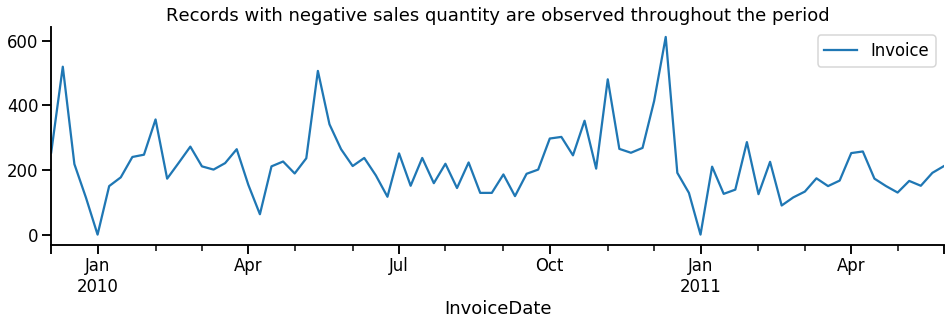

In [18]:
f, ax = plt.subplots(figsize = (16,4))
df_train[mask_neg_qty].groupby(pd.Grouper(key='InvoiceDate', freq='1W')).agg({
    'Invoice': 'count'
}).plot.line(ax = ax);

sns.despine();
plt.title("Records with negative sales quantity are observed throughout the period");
plt.show();

In [19]:
## well, just remove the negative records at the moment
df_train = df_train[~mask_neg_qty].copy()
print("Remaining observations: {:,.0f}".format(df_train.shape[0]))

Remaining observations: 716,460


## Feature Engineering

TO DO:

- [ ] item type
- [ ] item color?
- [ ] based on country
- [ ] day of week
- [ ] payday

In [21]:
df_train.head()

,index,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,subtotal,month_end_date
0,0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,83.4,2009-12-31 07:45:00
1,1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0,2009-12-31 07:45:00
2,2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085,United Kingdom,81.0,2009-12-31 07:45:00
3,3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085,United Kingdom,100.8,2009-12-31 07:45:00
4,4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085,United Kingdom,30.0,2009-12-31 07:45:00


In [23]:
df_train['Description']

0         15CM CHRISTMAS GLASS BALL 20 LIGHTS
1                          PINK CHERRY LIGHTS
2                         WHITE CHERRY LIGHTS
3                RECORD FRAME 7" SINGLE SIZE 
4              STRAWBERRY CERAMIC TRINKET BOX
                         ...                 
733204     BLUE WHITE PLASTIC RINGS LAMPSHADE
733205                  DOORMAT RED RETROSPOT
733206                  DOORMAT 3 SMILEY CATS
733207                     DOORMAT FAIRY CAKE
733208             FLOOR LAMP SHADE WOOD BASE
Name: Description, Length: 716460, dtype: object

In [22]:
df_train['Country'].value_counts()

United Kingdom          662457
EIRE                     11912
Germany                  11025
France                    8521
Netherlands               3619
Spain                     2143
Belgium                   1732
Switzerland               1727
Portugal                  1623
Australia                 1121
Channel Islands           1103
Sweden                    1047
Italy                      976
Cyprus                     844
Austria                    648
Finland                    641
Greece                     597
Norway                     567
Denmark                    496
United Arab Emirates       429
Japan                      388
Unspecified                380
Poland                     346
Hong Kong                  257
USA                        252
Singapore                  230
Lithuania                  189
Malta                      170
Iceland                    155
Bahrain                    124
RSA                        110
Israel                     110
Brazil  

## Split training and validation set

Use TimeseriesCV?

In [20]:
df_test.shape

(334162, 11)